In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['GoogleNews-vectors-negative300.bin']


In [2]:
stop_words=['is','the','of','has','and','are','like']
corpus=[
    'apple is fruit',
    'banana is fruit',
    'peach is fruit',
    'the color of apple is red',
    'the skin of banana is yellow',
    'peach is pink',
    'fruit has color',
    'monkey like yellow banana',
    'kids like red apple',
    'monkey like peach pink',
    'yellow red and pink are color',
]
def remove_stop_words(corpus):
    stop_words=['is','the','of','has','and','are','like']
    corpus_stop_words = []
    for word in corpus:
        temp = word.split(' ')
        for remove_stop in stop_words:
            if remove_stop in temp:
                temp.remove(remove_stop)
        corpus_stop_words.append(" ".join(temp))
    
    return corpus_stop_words
corpus = remove_stop_words(corpus)

In [3]:
num_of_words = 0
for line in corpus:
    num_of_words += len(line)
print('Num of words - %s'%(num_of_words))


Num of words - 160


In [4]:
words_append = []
for alphabet in corpus:
    for word in alphabet.split(' '):
        words_append.append(word)

words_append = set(words_append)

word2int = {}
#Storing index position
for i,text in enumerate(words_append):
    word2int[text] = i

string_of_words = []
for word in corpus:
    string_of_words.append(word.split())
window = 2

sets_data = []
for text in string_of_words:
    for word_text, word in enumerate(text):
        for adjoint in text[max(word_text - window, 0) : min(word_text + window, len(text)) + 1] : 
            if adjoint != word:
                sets_data.append([word, adjoint])

In [5]:
import pandas as pd
for word in corpus:
    print(word)

data_frame = pd.DataFrame(sets_data, columns = ['input', 'label'])

apple fruit
banana fruit
peach fruit
color apple red
skin banana yellow
peach pink
fruit color
monkey yellow banana
kids red apple
monkey peach pink
yellow red pink color


In [6]:
import tensorflow as tf
import numpy as np

one_hot = len(words_append)
X = [] 
Y = [] 

# converting to one hot vectors
def one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(one_hot)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

for x, y in zip(data_frame['input'], data_frame['label']):
    X.append(one_hot_encoding(word2int[ x ]))
    Y.append(one_hot_encoding(word2int[ y ]))

# convert to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# placeholders 
x = tf.placeholder(tf.float32, shape=(None, one_hot))
y_label = tf.placeholder(tf.float32, shape=(None, one_hot))

# embedding dimension
embedding_dim = 2 

# hidden layer
W1 = tf.Variable(tf.random_normal([one_hot, embedding_dim]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([embedding_dim, one_hot]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training
train = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 
iteration = 20000
for i in range(iteration):
    sess.run(train, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.6888604
iteration 3000 loss is :  1.9243283
iteration 6000 loss is :  1.8428564
iteration 9000 loss is :  1.823265
iteration 12000 loss is :  1.8138418
iteration 15000 loss is :  1.8063703
iteration 18000 loss is :  1.7983594


In [8]:
vec = sess.run(W1 + b1)
print(vec)
word2vec = pd.DataFrame(vec, columns = ['x1', 'x2'])
word2vec['word'] = words_append
word2vec = word2vec[['word', 'x1', 'x2']]
word2vec

[[ 0.04525757  0.4527635 ]
 [ 1.4918898  -3.3540804 ]
 [-3.2688763   0.52802217]
 [-3.4818594   0.5506753 ]
 [ 0.24738657 -2.7198927 ]
 [-0.07451829 -0.05576921]
 [-1.4659561   0.22306311]
 [ 2.885183    3.1579273 ]
 [ 0.4671663   0.7648525 ]
 [ 1.0157261  -1.7913674 ]
 [-4.4078474  -3.0777078 ]]


,word,x1,x2
0,color,0.045258,0.452763
1,fruit,1.491890,-3.354080
2,banana,-3.268876,0.528022
3,yellow,-3.481859,0.550675
4,monkey,0.247387,-2.719893
5,pink,-0.074518,-0.055769
6,peach,-1.465956,0.223063
7,kids,2.885183,3.157927
8,apple,0.467166,0.764853
9,red,1.015726,-1.791367


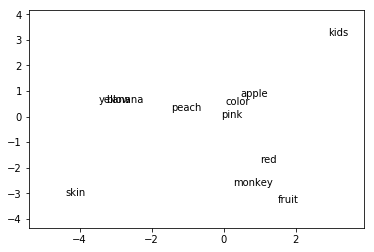

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(word2vec['word'], word2vec['x1'], word2vec['x2']):
    ax.annotate(word, (x1,x2 ))
    
pad = 1.0
x_axis_min = np.amin(vec, axis=0)[0] - pad
y_axis_min = np.amin(vec, axis=0)[1] - pad
x_axis_max = np.amax(vec, axis=0)[0] + pad
y_axis_max = np.amax(vec, axis=0)[1] + pad
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()